In [2]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

# Example 7. Cell Counting

Trains a U-Net to locate spherical particles in 3d.

## 1. Setup

Imports and defines the objects needed for this example.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import deeptrack as dt

IMAGE_SIZE = 128
MIN_Z = 2e-6
MAX_Z = 30e-6
Z_SCALE = 5e-7
PIXEL_SCALE = 3.45e-7

## 2. Defining the dataset

In [5]:
pupil = dt.HorizontalComa(coefficient=lambda: 2 +  3*np.random.rand()) + dt.VerticalComa(coefficient=lambda:-2 - np.random.rand()*2)

optics = dt.Brightfield(
    NA=1.3,
    wavelength=633e-9,
    magnification=1,
    resolution=lambda magnification: (PIXEL_SCALE * magnification,) * 2 + (Z_SCALE * magnification,),
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    upscale=1,
    pupil=pupil
)

In [6]:
particles = dt.MieParticle(
    position=lambda: 20 + np.random.rand(2) * (IMAGE_SIZE - 40),
    z=lambda: + MIN_Z / Z_SCALE + (np.random.rand() * (MAX_Z / Z_SCALE - MIN_Z / Z_SCALE)),
    position_unit="pixel",
    refractive_index=lambda: 1.45 + np.random.rand() * 0.1,
    radius=lambda: 190e-9 + np.random.rand() * 100e-9,
)
particles = particles ** (lambda: np.random.randint(2, 8))

In [7]:
noise = dt.Poisson(snr=lambda: 7 + np.random.rand() * 10, background=1)

gradient = dt.IlluminationGradient(gradient=lambda: np.random.randn(2)*0.0001)

normalization = dt.NormalizeMinMax(min=lambda:np.random.rand()*0.3, max=lambda min: min + 0.7 + np.random.rand()*0.3)

In [8]:
dataset = optics(particles) + noise + gradient + normalization

Visualizing the dataset

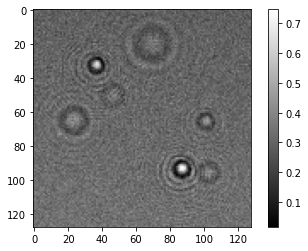

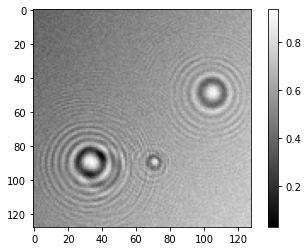

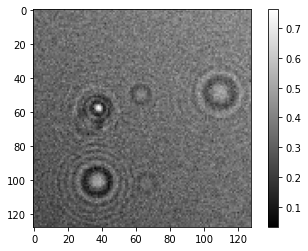

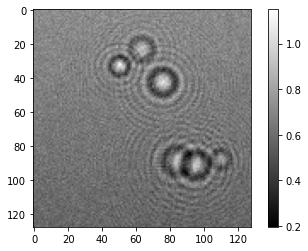

In [9]:
for _ in range(4):
    image = dataset.update().resolve()
    plt.imshow(image[:, :, 0], cmap="gray")
    plt.colorbar()
    plt.show()

## 3. Defining the target

In [13]:
number_of_features = int(MAX_Z / Z_SCALE -  MIN_Z / Z_SCALE)
radius = 5

X, Y, Z = np.mgrid[:radius*2, :radius*2, :radius*2]

SPHERE = (X-radius+0.5)**2 + (Y-radius+0.5)**2 + (Z-radius+0.5)**2 < radius**2

def mask(particle):  
    output = np.zeros((*SPHERE.shape[0:2], number_of_features))
    z = int(np.round(particle.get_property("z") -  MIN_Z / Z_SCALE))
    z0 = np.max([z, 0])
    zs0 = z0 - z
    z1 = np.min([z+SPHERE.shape[2], number_of_features])
    zs1 = z1 - z0
    output[:, :, z0:z1] = SPHERE[:, :, zs0:zs1]
    return output


label = dt.SampleToMasks(
    lambda: mask,
    number_of_masks=number_of_features,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE)
)


def get_label(image):
    return label.update().resolve(image)

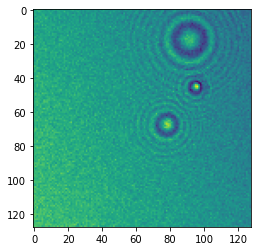

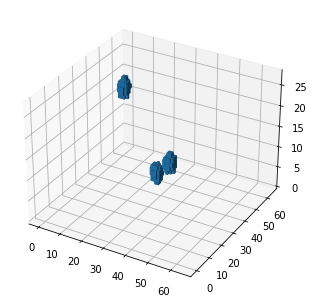

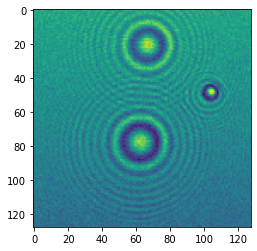

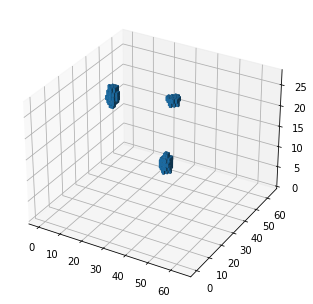

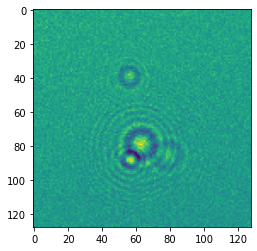

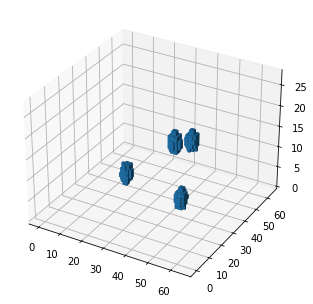

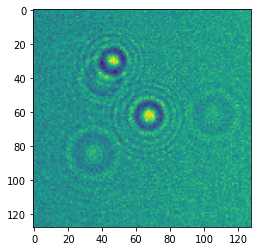

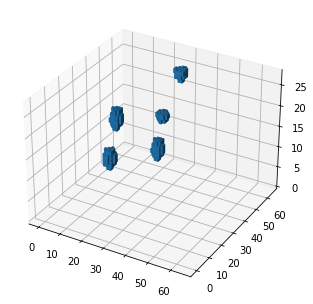

In [14]:
from mpl_toolkits.mplot3d import axes3d, Axes3D 

for _ in range(4):
    image = dataset.update().resolve()
    ground_truth = get_label(image)
    fig = plt.figure()
    plt.imshow(image[:, :, 0])
    plt.show()
    fig = plt.figure()
    ax = Axes3D(fig)
#     ax.axis('equal')
    ax.voxels(ground_truth[::2, ::2, ::2])
    
    plt.show()
#     for z in range(100):
#         plt.imshow(ground_truth[:, z, :])
#         plt.show()

In [6]:
from deeptrack.models import unet
from deeptrack.losses import weighted_crossentropy, nd_mean_squared_error


weight = [20, 1]
model = unet(
    input_shape=(None, None, 1),
    steps_per_pooling=1,
    conv_layers_dimensions=(32, 64, 128,),
    base_conv_layers_dimensions=(128, 128),
    output_conv_layers_dimensions=(64, 64),
    loss=weighted_crossentropy(weight),
    output_activation="sigmoid",
    number_of_outputs=number_of_features,
    metrics=[weighted_crossentropy((1, 1))]
)

# model.load_weights("holo3d.h5")
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 3 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 18496       max_pooling2d[0][0]              
_______________________________________________________________________________________

In [7]:
# from keras.callbacks import EarlyStopping
# augmented_dataset = FlipLR(FlipUD(FlipDiagonal(dataset)))

validation_set = []
validation_labels = []
for _ in range(256):
    val_image = dataset.update().resolve()
    val_label = get_label(val_image)
    validation_set.append(val_image)
    validation_labels.append(val_label)
    
validation_set = (
    np.array(validation_set),
    np.array(validation_labels),
)


generator = dt.generators.ContinuousGenerator(
    dataset,
    get_label,
    min_data_size=2000,
    max_data_size=4000,
    batch_size=32
)

with generator:
    

    while True:
        h = model.fit(generator,
            epochs=100,
            validation_data=validation_set
        )


        

Epoch 1/1001999 / 2000 samples before starting training
63/63 [==============================] - 22s 348ms/step - loss: 0.0129 - unet_crossentropy: 0.0693 - val_loss: 0.0086 - val_unet_crossentropy: 0.0185
Epoch 2/100
63/63 [==============================] - 23s 359ms/step - loss: 0.0062 - unet_crossentropy: 0.0223 - val_loss: 0.0042 - val_unet_crossentropy: 0.0220
Epoch 3/100
63/63 [==============================] - 22s 347ms/step - loss: 0.0034 - unet_crossentropy: 0.0156 - val_loss: 0.0027 - val_unet_crossentropy: 0.0117
Epoch 4/100
63/63 [==============================] - 22s 342ms/step - loss: 0.0027 - unet_crossentropy: 0.0140 - val_loss: 0.0025 - val_unet_crossentropy: 0.0145
Epoch 5/100
63/63 [==============================] - 22s 344ms/step - loss: 0.0024 - unet_crossentropy: 0.0131 - val_loss: 0.0020 - val_unet_crossentropy: 0.0108
Epoch 6/100
63/63 [==============================] - 22s 351ms/step - loss: 0.0021 - unet_crossentropy: 0.0109 - val_loss: 0.0016 - val_unet_cross

Epoch 97/100
63/63 [==============================] - 55s 877ms/step - loss: 3.8680e-04 - unet_crossentropy: 0.0026 - val_loss: 6.3829e-04 - val_unet_crossentropy: 0.0026
Epoch 98/100
63/63 [==============================] - 33s 526ms/step - loss: 3.9973e-04 - unet_crossentropy: 0.0027 - val_loss: 6.3917e-04 - val_unet_crossentropy: 0.0026
Epoch 99/100
63/63 [==============================] - 44s 691ms/step - loss: 3.8352e-04 - unet_crossentropy: 0.0026 - val_loss: 6.4287e-04 - val_unet_crossentropy: 0.0028
Epoch 100/100
63/63 [==============================] - 62s 979ms/step - loss: 3.6021e-04 - unet_crossentropy: 0.0025 - val_loss: 6.3175e-04 - val_unet_crossentropy: 0.0027
Epoch 1/100
125/125 [==============================] - 131s 1s/step - loss: 3.9478e-04 - unet_crossentropy: 0.0026 - val_loss: 6.2376e-04 - val_unet_crossentropy: 0.0029
Epoch 2/100
125/125 [==============================] - 123s 985ms/step - loss: 3.9042e-04 - unet_crossentropy: 0.0026 - val_loss: 6.2773e-04 - va

KeyboardInterrupt: 

In [34]:
model.save("./models/3dtracker.h5")
import scipy.io
scipy.io.savemat("../../figures/holo_loss.mat", h.history)

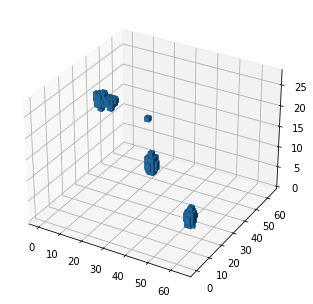

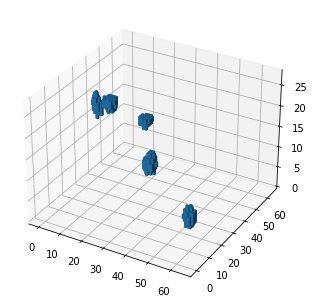

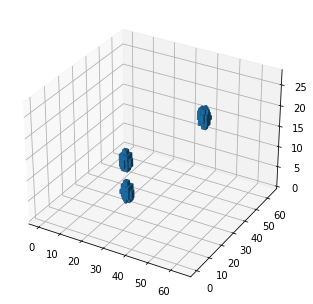

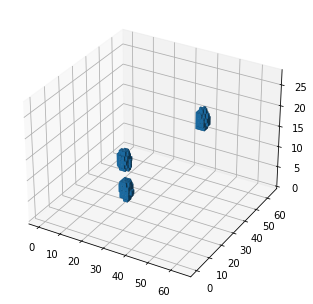

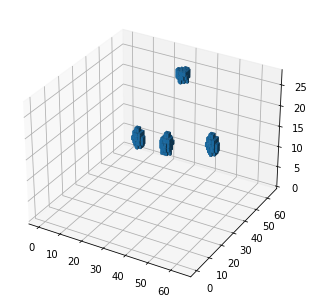

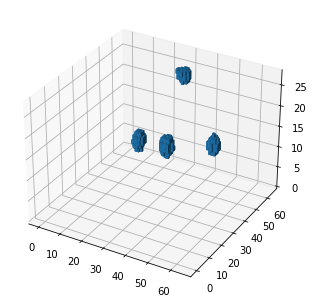

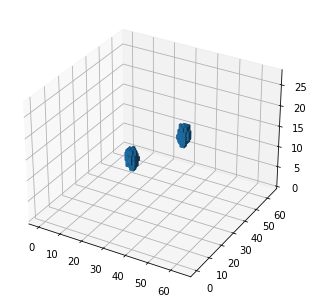

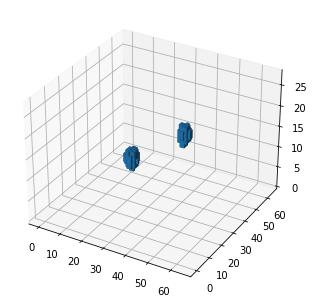

In [35]:
for _ in range(4):
    image = dataset.update().resolve()
    ground_truth = get_label(image)
    prediction = model.predict(np.array([image]))
    fig = plt.figure()
#     plt.imshow(image[:, :, 0])
#     plt.show()
    ax = Axes3D(fig)
#     ax.axis('equal')
    ax.voxels(ground_truth[::2, ::2, ::2])
    
    plt.show()
    
    fig = plt.figure()
#     plt.imshow(image[:, :, 0])
#     plt.show()
    ax = Axes3D(fig)
#     ax.axis('equal')
    ax.voxels(prediction[0, ::2, ::2, ::2] > 0.9)
    
    plt.show()
#     for z in range(100):
#         plt.imshow(ground_truth[:, z, :])
#         plt.show()

In [37]:
import scipy.io

video = scipy.io.loadmat(r"C:\Users\bmidt\Holography tracking\HoloCode\res\1Every1_2_movie_1.aviProcessedField0.mat")
tracesbatch = scipy.io.loadmat(r"C:\Users\bmidt\Holography tracking\HoloCode\res\1Every1_2_movie_1.aviCompletedTraces")

In [38]:
traces = tracesbatch["CompletedTraces"]

In [39]:
import gc

gc.collect()


0

In [40]:
mapping =  scipy.io.loadmat(r"C:\Users\bmidt\Holography tracking\HoloCode\mapping.mat")["Mapping"]
v = video["ProcessedField"][0]
import matplotlib.pyplot as plt
import numpy as np
vout = []
mapping = np.transpose(mapping)
idx = 0
for frame in v:
    im = np.zeros(mapping.shape) * 0j
    im[mapping > 0] = frame[:, 0]
    im = np.fft.ifft2(im)
    out = dt.AveragePooling(kernel_size=(3, 3)).update().resolve(np.abs(im + 1) ** 2, keep_size=False)
    
    
    vout.append(out)
    idx += 1
    if idx > 100:
        break
    
vout = np.array(vout)

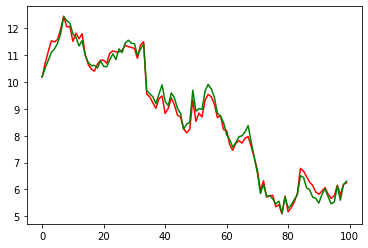

In [49]:
import skimage
trace = traces[0, 94]
trace = trace[0][0][1]

x = trace[:,1] / 0.115 / 3
y = trace[:,2] / 0.115 / 3
z = trace[:,3] 

predicted_z = []
positions = []
frames = []
for i in range(0, 100):

    try:
        t = int(trace[i, 0])

        frame = np.expand_dims(vout[i, :, :], axis=-1)
        frame -= np.min(frame)
        frame /= np.max(frame)

        frame = frame[int(x[i])-48:int(x[i])+48, int(y[i])-48:int(y[i])+48, :]

        frames.append(frame)
        outp = model.predict(np.array([frame])) > 0.9
#         fig = plt.figure()
#         ax = Axes3D(fig)
#         #     ax.axis('equal')
#         ax.voxels(outp[0, ::2, ::2, ::2] > 0.8)

#         plt.show()
        CC = skimage.measure.label(outp[0])
        props = skimage.measure.regionprops(CC)
        centroids = [prop["Centroid"] for prop in props]
        idx= np.argmin(np.sum(np.abs(np.array(centroids)[:, :2]-60), axis=1))
        
        predicted_z.append((centroids[idx][2] + MIN_Z / Z_SCALE) * Z_SCALE / 1e-6)
        
        c = np.array(centroids[idx])
        c[0] += x[i]
        c[1] += y[i]
        c[2] = (c[2] + MIN_Z / Z_SCALE) * Z_SCALE / 1e-6
        positions.append(c)
#         print(i)
#         plt.imshow(frame[:, :, 0])
#         plt.show()
    except Exception as e:
        print(e)
        break

plt.plot(np.array(predicted_z), c="r")
plt.plot(z[:len(predicted_z)] * 1.5, c="g")
plt.show()






# scipy.io.savemat("../../figures/holography_predictions_new.mat", {
#     "frames": np.array(frames),
#     "p": np.array(trace),
#     "pred_p": np.array(positions)
# })

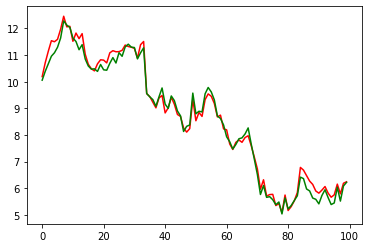

In [55]:
plt.plot(np.array(predicted_z), c="r")
plt.plot(z[:len(predicted_z)] * 1.48, c="g")
plt.show()

In [ ]:
import skimage

positions = []
frames = []



for i in range(100):
    frame = vout[i:i+1, -400:, -400:] * 0.7 - 0.35

    frames.append(frame)

    outp = model.predict_on_batch(np.expand_dims(frame, axis=-1)) > 0.95

    CC = skimage.measure.label(outp[0])
    props = skimage.measure.regionprops(CC)
    centroids = np.array([prop["Centroid"] for prop in props])
    centroids[:, -1] = (centroids[:, -1] + MIN_Z / Z_SCALE) * Z_SCALE / 1e-6
    positions.append(centroids)


# 
# import scipy

# scipy.io.savemat("../../figures/holography_video.mat", {
#     "frames": np.array(frames),
#     "positions": positions
# })